# Data Collection

Collect historical price data for Ethereum.

Gather news articles or headlines related to Crypto.

<img src="./OIP.jpg">

# Importing the libraries

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import ast
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,
)

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Importing the datasets

In [54]:
eth_dataset = pd.read_csv("ETH-USD.csv")
news_dataset = pd.read_csv("cryptonews.csv")

In [55]:
eth_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [56]:
news_dataset.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [57]:
news_dataset.dtypes

date         object
sentiment    object
source       object
subject      object
text         object
title        object
url          object
dtype: object

In [58]:
eth_dataset.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Data Preprocessing

In [59]:
print(eth_dataset.shape)
print(news_dataset.shape)

(1598, 7)
(18543, 7)


In [60]:
eth_dataset['date'] = pd.to_datetime(eth_dataset['Date'])
eth_dataset.drop(columns=["Date"], inplace=True)
min_date1 = eth_dataset['date'].min()
max_date1 = eth_dataset['date'].max()

In [61]:
news_dataset['date'] = pd.to_datetime(news_dataset['date'])
news_dataset = news_dataset.sort_values(by='date', ascending=True)
min_date = news_dataset['date'].min()
max_date = news_dataset['date'].max()
news_dataset.set_index('date', inplace=True)

In [62]:
print(f"The range of dates in news data is from {min_date} to {max_date}")
print(f"The range of dates in eth data is from {min_date1} to {max_date1}")

The range of dates in news data is from 2021-10-12 20:00:00 to 2023-04-05 06:52:09
The range of dates in eth data is from 2017-11-09 00:00:00 to 2022-03-25 00:00:00


In [63]:
start_date = '2021-10-12'
end_date = '2023-04-05'

# Filter the DataFrame based on the date range
filtered_eth_data = eth_dataset[(eth_dataset['date'] >= start_date) & (eth_dataset['date'] <= end_date)]

In [64]:
filtered_news_data = news_dataset

filtered_news_data['sentiment'] = filtered_news_data['sentiment'].apply(ast.literal_eval)

filtered_news_data['sentiment_mapped'] = filtered_news_data['sentiment'].apply(lambda x: -1 if 'class' in x and x['class'] == 'negative' else (1 if 'class' in x and x['class'] == 'positive' else 0))

filtered_news_data.drop(columns=filtered_news_data.columns.difference(['sentiment_mapped']), inplace=True)

filtered_news_data = filtered_news_data.reset_index()

filtered_news_data['date'] = filtered_news_data['date'].dt.strftime('%Y-%m-%d')

# Group by date and calculate the majority vote sentiment
majority_vote_sentiment = filtered_news_data.groupby('date')['sentiment_mapped'].agg(lambda x: mode(x)[0][0] if not x.empty else None).reset_index()

# Group by date and calculate the sum of sentiments
sum_sentiments = filtered_news_data.groupby('date')['sentiment_mapped'].sum().reset_index()

# Merge the two results on the 'Date' column
filtered_news_data = pd.merge(majority_vote_sentiment, sum_sentiments, on='date', suffixes=('_majority_vote', '_sum'))

filtered_news_data['date'] = pd.to_datetime(filtered_news_data['date'])

C:\Users\hutha\AppData\Local\Temp\ipykernel_11612\2420629804.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote_sentiment = filtered_news_data.groupby('date')['sentiment_mapped'].agg(lambda x: mode(x)[0][0] if not x.empty else None).reset_index()


In [65]:
merged_data = pd.merge(filtered_eth_data, filtered_news_data, on='date', how='left')

In [66]:
merged_data.head()

,Open,High,Low,Close,Adj Close,Volume,date,sentiment_mapped_majority_vote,sentiment_mapped_sum
0,3546.477783,3546.477783,3407.338135,3492.573242,3492.573242,18109578443,2021-10-12,1.0,1.0
1,3492.753662,3607.741699,3417.602051,3606.201660,3606.201660,16211275589,2021-10-13,NaN,NaN
2,3604.958984,3819.258545,3590.275146,3786.014160,3786.014160,19443499909,2021-10-14,NaN,NaN
3,3790.154297,3895.466309,3735.363525,3862.634766,3862.634766,20966841512,2021-10-15,0.0,0.0
4,3865.666504,3962.453125,3805.885986,3830.382080,3830.382080,16578095629,2021-10-16,NaN,NaN


In [67]:
merged_data.isnull().sum()

Open                               0
High                               0
Low                                0
Close                              0
Adj Close                          0
Volume                             0
date                               0
sentiment_mapped_majority_vote    25
sentiment_mapped_sum              25
dtype: int64

In [68]:
merged_data.fillna(0, inplace=True)

In [69]:
merged_data.isnull().sum()

Open                              0
High                              0
Low                               0
Close                             0
Adj Close                         0
Volume                            0
date                              0
sentiment_mapped_majority_vote    0
sentiment_mapped_sum              0
dtype: int64

In [70]:
merged_data['next_day_close'] = merged_data['Close'].shift(-1)
merged_data['price_movement'] = (merged_data['next_day_close'] > merged_data['Close']).astype(int)

In [71]:
merged_data.dropna(inplace=True)
merged_data.drop(columns = ["Adj Close", "next_day_close"], inplace = True)

In [72]:
merged_data

,Open,High,Low,Close,Volume,date,sentiment_mapped_majority_vote,sentiment_mapped_sum,price_movement
0,3546.477783,3546.477783,3407.338135,3492.573242,18109578443,2021-10-12,1.0,1.0,1
1,3492.753662,3607.741699,3417.602051,3606.201660,16211275589,2021-10-13,0.0,0.0,1
2,3604.958984,3819.258545,3590.275146,3786.014160,19443499909,2021-10-14,0.0,0.0,1
3,3790.154297,3895.466309,3735.363525,3862.634766,20966841512,2021-10-15,0.0,0.0,0
4,3865.666504,3962.453125,3805.885986,3830.382080,16578095629,2021-10-16,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
159,2946.547607,2956.965576,2826.107422,2860.459229,12684727326,2022-03-20,1.0,3.0,1
160,2860.103271,2954.556641,2838.250488,2897.976563,15206116098,2022-03-21,1.0,11.0,1
161,2897.774170,3040.382813,2892.544434,2973.131104,16830539230,2022-03-22,0.0,13.0,1
162,2973.145020,3036.752197,2933.306641,3031.067139,16008767658,2022-03-23,0.0,14.0,1


# Data Exploration

<Figure size 1200x800 with 0 Axes>

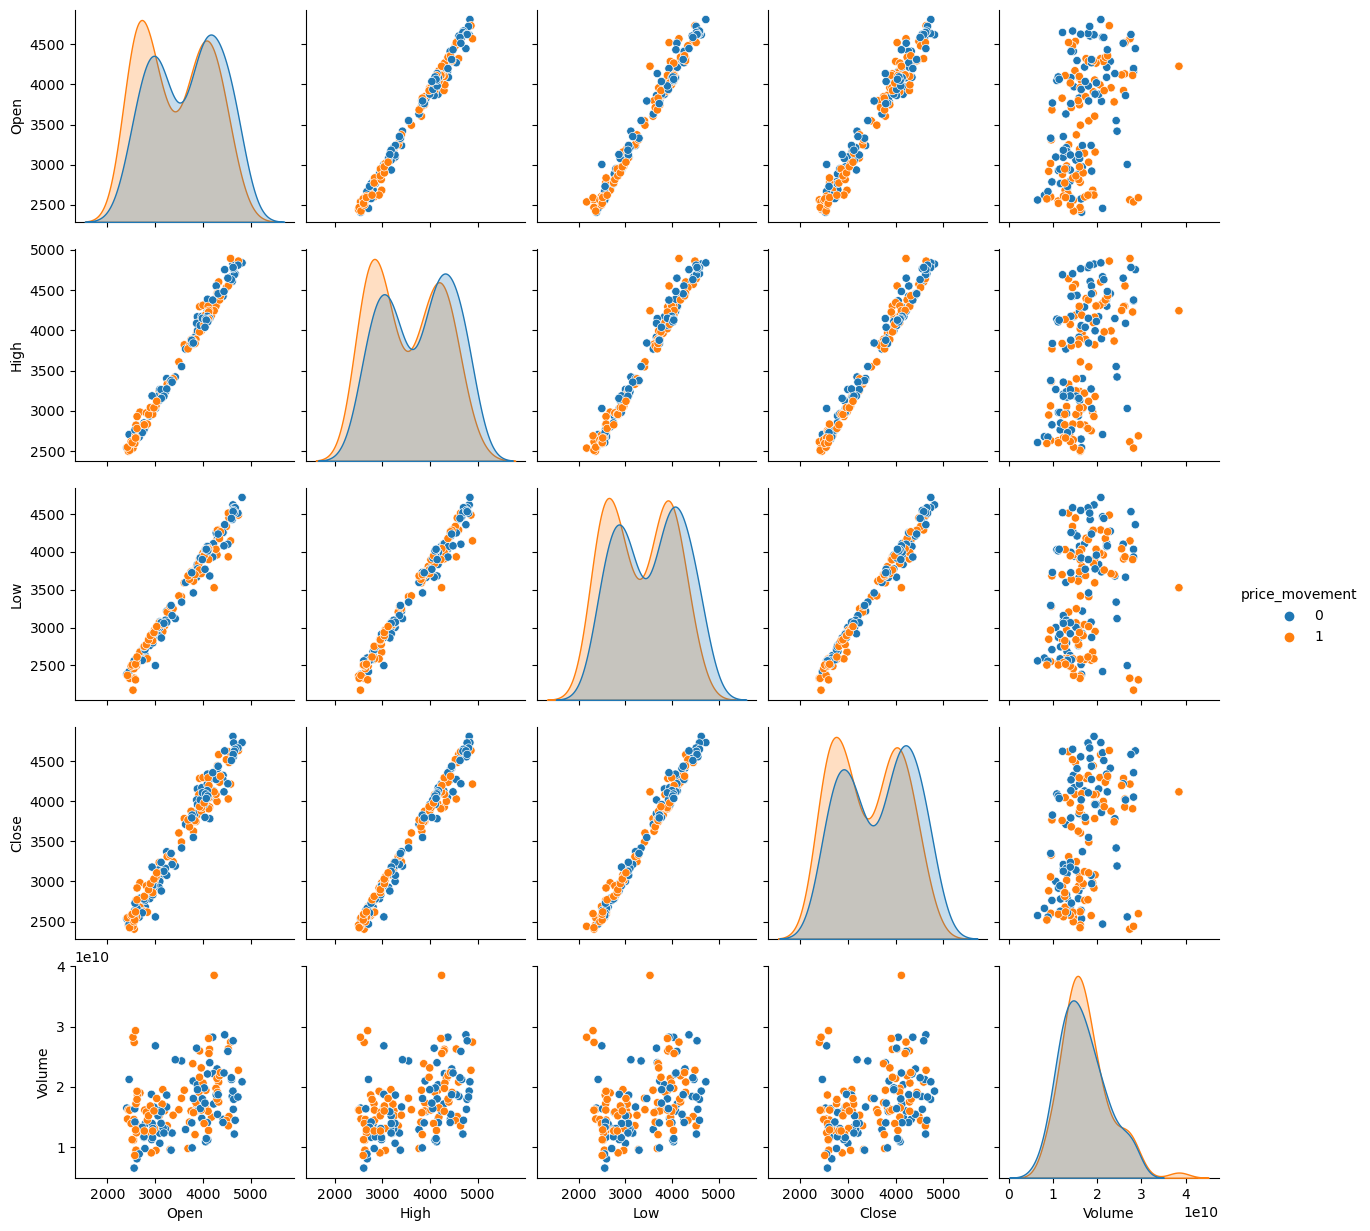

In [73]:
plt.figure(figsize=(12, 8))
sns.pairplot(merged_data[['Open', 'High', 'Low', 'Close', 'Volume', 'price_movement']],
             hue='price_movement')
plt.show()

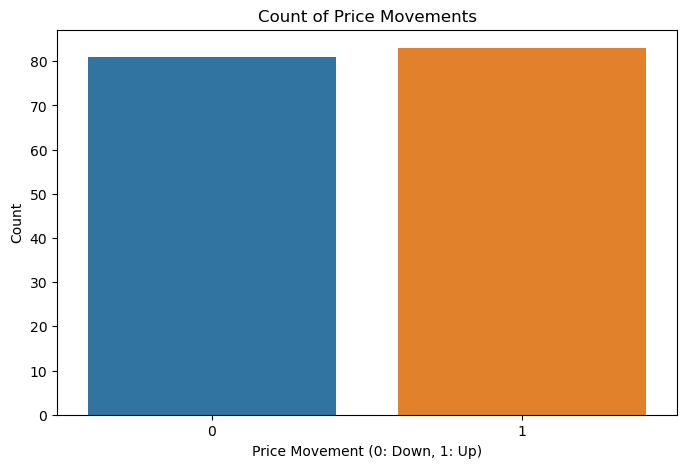

In [74]:
plt.figure(figsize=(8, 5))
sns.countplot(x='price_movement', data=merged_data)
plt.title('Count of Price Movements')
plt.xlabel('Price Movement (0: Down, 1: Up)')
plt.ylabel('Count')
plt.show()

# Feature engineering

Simple Moving Average (SMA)

In [75]:
sma_window = 20
merged_data['SMA_20'] = merged_data['Close'].rolling(window=sma_window).mean()

Exponential Moving Average (EMA)

In [76]:
ema_window = 12
alpha = 2 / (ema_window + 1)
merged_data['EMA_12'] = merged_data['Close'].ewm(alpha=alpha, adjust=False).mean()

Relative Strength Index (RSI)

In [77]:
rsi_window = 14
price_diff = merged_data['Close'].diff(1)
gain = price_diff.where(price_diff > 0, 0)
loss = -price_diff.where(price_diff < 0, 0)

avg_gain = gain.rolling(window=rsi_window, min_periods=1).mean()
avg_loss = loss.rolling(window=rsi_window, min_periods=1).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

merged_data['RSI_14'] = rsi

Extracting features from the 'date' column

In [78]:
merged_data['day'] = merged_data['date'].dt.day
merged_data['month'] = merged_data['date'].dt.month
merged_data['year'] = merged_data['date'].dt.year
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek  # Monday=0, Sunday=6
merged_data['quarter'] = merged_data['date'].dt.quarter

In [79]:
print("Missing Values:\n", merged_data.isnull().sum())

Missing Values:
 Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
date                               0
sentiment_mapped_majority_vote     0
sentiment_mapped_sum               0
price_movement                     0
SMA_20                            19
EMA_12                             0
RSI_14                             1
day                                0
month                              0
year                               0
day_of_week                        0
quarter                            0
dtype: int64


In [80]:
merged_data.dropna(inplace = True)
print("Missing Values:\n", merged_data.isnull().sum())

Missing Values:
 Open                              0
High                              0
Low                               0
Close                             0
Volume                            0
date                              0
sentiment_mapped_majority_vote    0
sentiment_mapped_sum              0
price_movement                    0
SMA_20                            0
EMA_12                            0
RSI_14                            0
day                               0
month                             0
year                              0
day_of_week                       0
quarter                           0
dtype: int64


In [81]:
merged_data.drop(columns = ["date"], inplace = True)

# Splitting the dataset into the Training set and Test set

In [82]:
target = 'price_movement'
predictor = [col for col in merged_data.columns if col != target]

In [83]:
predictor

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'sentiment_mapped_majority_vote',
 'sentiment_mapped_sum',
 'SMA_20',
 'EMA_12',
 'RSI_14',
 'day',
 'month',
 'year',
 'day_of_week',
 'quarter']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(merged_data[predictor], merged_data[target],
                                                    test_size=0.2)

In [142]:
print("Training set shape: ", X_train.shape)
print("Test set shape: ", X_test.shape)

Training set shape:  (116, 15)
Test set shape:  (29, 15)


### Scaling

In [143]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training Support Vector Machine-SVM model

In [201]:
svm_classifier = SVC(kernel = "linear")

svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [202]:
y_pred = svm_classifier.predict(X_test)

In [203]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


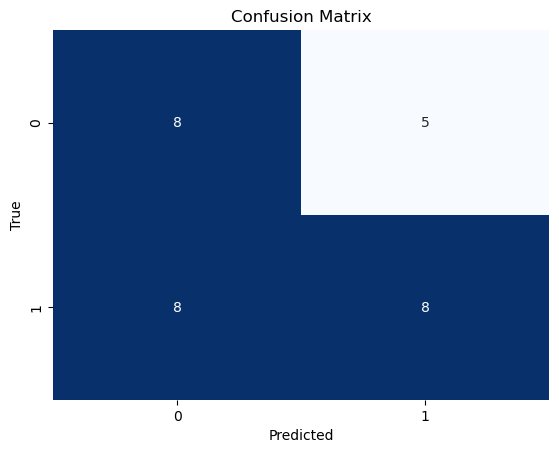

In [204]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Applying k-Fold Cross Validation

In [205]:
accuracies = cross_val_score(estimator = svm_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 55.30 %
Standard Deviation: 10.09 %


### Applying Grid Search to find the best model and the best parameters

In [207]:
parameters = [{'C' : [0.25, 0.5, 0.75, 1], 'kernel' : ['linear']},
             {'C' : [0.25, 0.5, 0.75, 1], 'kernel' : ['rbf'], 'gamma' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = svm_classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best_Parameters: ", best_parameters)

Best Accuracy: 60.61 %
Best_Parameters:  {'C': 0.5, 'kernel': 'linear'}


# Training RandomForest model

In [148]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [149]:
y_pred = rf_classifier.predict(X_test)

In [150]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


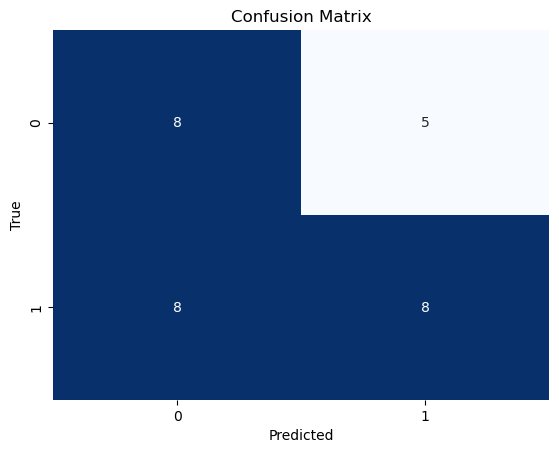

In [151]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Applying k-Fold Cross Validation

In [208]:
accuracies = cross_val_score(estimator = rf_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 54.32 %
Standard Deviation: 16.28 %


### Applying Grid Search to find the best model and the best parameters

In [209]:
parameters = [
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
]

grid_search = GridSearchCV(estimator = rf_classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best_Parameters: ", best_parameters)

Best Accuracy: 55.38 %
Best_Parameters:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


# Training Multi-Layer Perceptron (MLP) model

In [189]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 256), max_iter=500, random_state=42)

mlp_classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 256), max_iter=500, random_state=42)

In [190]:
y_pred = mlp_classifier.predict(X_test)

In [191]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


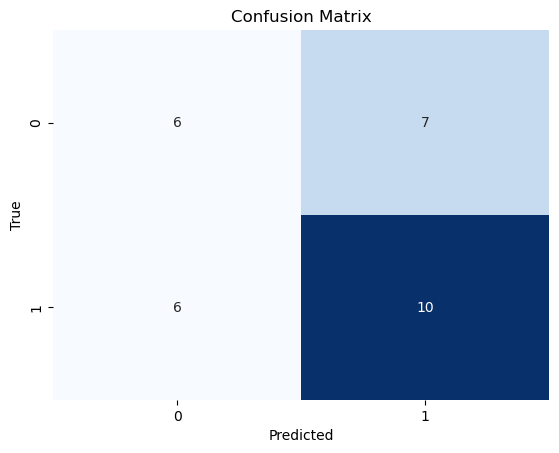

In [192]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Applying k-Fold Cross Validation

In [210]:
accuracies = cross_val_score(estimator = mlp_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 51.82 %
Standard Deviation: 20.35 %


### Applying Grid Search to find the best model and the best parameters

In [211]:
parameters = [
    {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'activation': ['relu', 'tanh', 'logistic'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.001, 0.01], 'max_iter': [200, 300, 500]}
]

grid_search = GridSearchCV(estimator = mlp_classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best_Parameters: ", best_parameters)

Best Accuracy: 60.61 %
Best_Parameters:  {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 300, 'solver': 'adam'}


C:\Users\hutha\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
